# Calling the Rewiring America Health Impacts API from Python

In December, Rewiring America released our second public API. The API is based on data and models
we built to type to answer questions about how the health of people across the county would be
affected if communities were to electrify their homes in various ways. 

You can read about the research on [our web site](https://www.rewiringamerica.org/research/home-electrification-health-benefits),
and in the [New York Times](https://www.nytimes.com/2024/12/10/climate/heat-pumps-savings.html).
Reports and new coverage are awesome, but we also wanted to make sure it
was easy for researchers to get the underlying data, sliced and diced to meet their needs. So we
created an API.

In this notebook we are going to demonstrate how you can call the API directly from Python and what
kinds of questions you can ask it.

## Python Environment Setup

The Rewiring America APIs can be called from any Python 3.8+ environment using the requests package. The Health Impacts AP returns data in tabular form, so it is also useful to have Pandas installed in your virtual environment. If you don’t already have both of these packages installed, you can install them with

```shell
pip install requests
```

and

```shell
pip install pandas
```

Those should be the only things you need to ensure are installed before you can run the code in this notebook.

## Imports and configuration

Once we have our environment set up, our next step is to import the packages we are going to use

In [1]:
import requests
import pandas as pd

We also need the URL of the Health Effects API.

In [2]:
#URL = "https://api.rewiringamerica.org/api/v1/health-impacts"
URL = "http://127.0.0.1:8080/api/v1/health-impacts/"

## Our First API Call

### Payload

We are going to start out with a basic call to the API, and then we will build up from there.

In our first call, we will pass in 

- a single metric (premature mortality),
- a single upgrade (a medium efficiency heat pump),
- a single state (Wisconsin).

The return value will be the nationwide impact on premature mortality in person-years if every home
in Wisconsin were to upgrade to a heat pump. Note that the effects are nationwide, because winds can
blow pollutants into nearby states. But the bulk of the effect will occur in and near the state of Wisconsin.

In [3]:
payload = {
    "metrics": "premature_mortality_incidence_delta",
    "upgrade": "med_eff_hp_hers_sizing_no_setback",
    "state": "WI"
}

### Headers

In addition to the payload, we will send in some standard headers with each call, to indicate
that we are sending the payload in JSON form and we expect the results to come back in JSON.

In [4]:
headers = {
    "Content-Type": "application/json",
    "Accept": "application/json",
}

### Make the Call

Now we can make the actual call, look at the response code, which should be 200 to indicate
that everything was OK, and then the text of the response.

In [5]:
# Make the API call:
response = requests.post(URL, json=payload, headers=headers)

In [6]:
response.status_code

200

In [7]:
response.text

'{"data":[{"state":"WI","premature_mortality_incidence_delta":27.999598212086404,"number_of_households":2189591}]}'

### Data from the Response

Now we will make a data frame out of the JSON data that comes back from the call.

We asked for one state, so the response will have one row. It will also have a column
to indicate what the state is. This will be more important when we ask for more than
one state. We asked for one metric, so it will have a column for that. It will also
have a column for the number of households in the state.

In [8]:
df_data = pd.DataFrame(response.json()["data"])

In [9]:
df_data

,state,premature_mortality_incidence_delta,number_of_households
0,WI,27.999598,2189591


So looking at the results, we see that if all of the households in Wisconsin were to switch to heat pumps, 28 lives per year would be saved.

## Expanding our Query to All States

Now let's make a second query. Just like in the first one, we
Wpass in a single metric (premature mortality) and a single upgrade (a
medium efficiency heat pump). But unlike in the Wisconsin example, we do not pass in a state. Therefore, we get results for all states in the continental United States.

In [10]:
payload_all_states = {
    "metrics": "premature_mortality_incidence_delta",
    "upgrade": "med_eff_hp_hers_sizing_no_setback"
}

response_all_states = requests.post(URL, json=payload_all_states, headers=headers)

In [11]:
df_data_all_states = pd.DataFrame(response_all_states.json()["data"])
df_data_all_states

,state,premature_mortality_incidence_delta,number_of_households
0,AL,15.862550,1409929
1,AR,11.267364,884020
2,AZ,2.975578,1848670
3,CA,166.436745,12098560
4,CO,27.328565,1904118
5,CT,43.784559,1290316
6,DC,10.717516,236562
7,DE,11.109927,299274
8,FL,10.920949,4840199
9,GA,38.972264,2898066


Our resulting dataframe has the same columns as before, but since we did not 
ask for a specific state, we got all of them. 

### Deriving New Metrics

Since the data is in a data frame, we can manipulate it a variety of ways. For
example, we could add a column for the ratio of change in mortality to number
of households, then see which states have the highest value for that derived
metric.

In [12]:
df_data_all_states["mortality_per_household"] = (
    df_data_all_states["premature_mortality_incidence_delta"] / df_data_all_states["number_of_households"]
)

df_data_all_states.nlargest(10, "mortality_per_household")

,state,premature_mortality_incidence_delta,number_of_households,mortality_per_household
32,NY,870.082923,6859572,0.000127
29,NJ,204.186709,3061262,0.000067
17,MA,131.983145,2449155,0.000054
37,RI,19.806513,392252,0.000050
18,MD,89.941786,1791043,0.000050
6,DC,10.717516,236562,0.000045
36,PA,199.916981,4489835,0.000045
20,MI,141.640629,3679665,0.000038
7,DE,11.109927,299274,0.000037
5,CT,43.784559,1290316,0.000034


## County-by-County Data in New Jersey

Just as in the previous examples, we pass in a single metric (premature mortality), a single upgrade (a medium
efficiency heat pump), a state (New Jersey), and a value of \"*\" for the county. This gives us results for all counties
in New Jersey. For each county, we get the nationwide effects, just as we did for the Wisconsin and all states examples.

In [13]:
payload_nj_counties = {
    "metrics": ["premature_mortality_incidence_delta"],
    "upgrade": "med_eff_hp_hers_sizing_no_setback",
    "state": "NJ",
    "county_fips": "*"
}

response_nj_counties = requests.post(URL, json=payload_nj_counties, headers=headers)

In [14]:
df_data_nj_counties = pd.DataFrame(response_nj_counties.json()["data"])
df_data_nj_counties

,state,premature_mortality_incidence_delta,county,number_of_households
0,NJ,2.484353,001,91768
1,NJ,56.538151,003,330509
2,NJ,16.011621,005,153027
3,NJ,23.783300,007,176998
4,NJ,0.739929,009,38257
5,NJ,1.422779,011,46731
6,NJ,18.586102,013,268039
7,NJ,12.135478,015,99274
8,NJ,27.337756,017,235109
9,NJ,0.685206,019,44794


### Comparing to Statewide

The data we got in our last request was just for the state of New Jersey, and was disaggreated
by county. So if we add up the effects of all of the counties, they should add up to the statewide
number we got for New Jersey when we did the query for all states. We can verify this now.

In [15]:
statewide_nj_mortality = df_data_all_states[df_data_all_states["state"] == 'NJ']["premature_mortality_incidence_delta"].iloc[0]
sum_of_nj_county_mortality = df_data_nj_counties["premature_mortality_incidence_delta"].sum()

f"At the state level: {statewide_nj_mortality:.1f}; Summed over counties: {sum_of_nj_county_mortality:.1f}."

'At the state level: 204.2; Summed over counties: 204.2.'

## County by County Data in North Dakota

We can repeat the query we did in New Jersey for North Dakota.

In [16]:
payload_nd_counties = {
    "metrics": ["premature_mortality_incidence_delta"],
    "upgrade": "med_eff_hp_hers_sizing_no_setback",
    "state": "ND",
    "county_fips": "*"
}

response_nd_counties = requests.post(URL, json=payload_nd_counties, headers=headers)

### Any Warnings?

In earlier examples, we always just grabbed the `data` component out of the response, but we never
checked what else might be there. Let's do that.

In [17]:
response_nd_counties_json = response_nd_counties.json()

response_nd_counties_json.keys()

dict_keys(['data', 'warnings'])

We can check an earlier response and see if warnings were also there.

In [18]:
response_nj_counties.json().keys()

dict_keys(['data'])

There were no warnings in the the earlier calls. Let's see what warnings were present in this one.

In [19]:
response_nd_counties.json()["warnings"]

['Some results do not meet the recommended sample size of 5,000 households. Interpret these results with caution.']

### Look at the Data in Light of Warnings

OK, so now we know what the warning was, and when we look in the data that comes back,
we can heed the warning. First we will look at all counties, then we will restrict our attention
to those with at least the recommended sample size of 5,000.

In [20]:
df_data_nd_counties = pd.DataFrame(response_nd_counties.json()["data"])
df_data_nd_counties

,state,premature_mortality_incidence_delta,county,number_of_households
0,ND,-0.007302,001,1211
1,ND,-0.008486,003,3632
2,ND,-0.021805,005,2421
3,ND,-0.002022,007,242
4,ND,-0.014524,009,2906
5,ND,-0.006226,011,726
6,ND,-0.004193,013,1211
7,ND,-0.148502,015,33414
8,ND,0.098251,017,66828
9,ND,-0.002101,019,1937


In [21]:
df_data_nd_counties[df_data_nd_counties["number_of_households"] >= 5000]

,state,premature_mortality_incidence_delta,county,number_of_households
7,ND,-0.148502,015,33414
8,ND,0.098251,017,66828
17,ND,-0.025190,035,25424
29,ND,-0.070147,059,11622
38,ND,-0.004760,077,6295
44,ND,-0.042472,089,9443
46,ND,-0.042652,093,7506
50,ND,-0.076534,101,23002
52,ND,-0.071211,105,12349


## Query Multiple Metrics in Multiple States

Sometimes we want bulk data, not just data for one metric or one state. In this
example, we will query several metrics, one for each kind of emissions the model tracks, across three states, New York,
New Jersey, and Connecticut. We can do that by passing multiple values for these arguments to
the API.

In [22]:
payload_bulk = {
    "metrics": ["pm25-pri_kg_delta", "nh3_kg_delta", "nox_kg_delta", "voc_kg_delta", "so2_kg_delta"],
    "upgrade": "med_eff_hp_hers_sizing_no_setback",
    "state": ["NY", "NJ", "CT"]
}

In [23]:
response_bulk = requests.post(URL, json=payload_bulk, headers=headers)

In [24]:
df_data_bulk = pd.DataFrame(response_bulk.json()["data"])
df_data_bulk

,state,pm25-pri_kg_delta,nh3_kg_delta,nox_kg_delta,voc_kg_delta,so2_kg_delta,number_of_households
0,CT,379625.251018,5.174537e+05,4.971106e+06,1.952656e+05,-7.025032e+04,1290316
1,NJ,72953.855309,1.881648e+06,1.015888e+07,5.096962e+05,-1.061043e+06,3061262
2,NY,744221.992121,3.675171e+06,2.237453e+07,1.082938e+06,-1.175397e+06,6859572


Notice that now we have three rows, one for each state we requested, and instead of one metric column like we have gotten in the past,
we have several, one for each emission metric.

## Grouping Results

In this example, instead of aggregating results for all homes together,
we will group the homes by ranges of square footage.

In [25]:
payload_groups = {
    "metrics": "premature_mortality_incidence_delta",
    "upgrade": "med_eff_hp_hers_sizing_no_setback",
    "state": "WI",
    "groupby": "in_sqft_bin"
}

response_groups = requests.post(URL, json=payload_groups, headers=headers)


The result we got back contains data grouped into bins based on the square footage of homes.

In [26]:
df_groups = pd.DataFrame(response_groups.json()["data"])
df_groups

,state,in_sqft_bin,premature_mortality_incidence_delta,number_of_households
0,WI,0-1499,9.495158,1119372
1,WI,1500-2499,9.751330,682809
2,WI,2500-5499,5.756183,315497
3,WI,5500+,2.996928,71913


If we sum up the impact, we will find that it adds up to the number from our very first query at the top of this notebook.

In [27]:
grouped_sum = df_groups["premature_mortality_incidence_delta"].sum()
f"{grouped_sum:.1f}"

'28.0'

## Combine our Data with U.S. Census Maps

In this final section, we will import an library called `censusdis` that will let us grab
U.S. Census data. If you don't have this in your virtual environment, you can 

`pip install censusdis`

to get it.

### Additional Imports

In [28]:
import censusdis.data as ced
from censusdis.datasets import ACS5
import censusdis.maps as cem
from censusdis.states import NJ

### Download Map Data and Merge

In [29]:
gdf_nj_counties = ced.download(
    ACS5, 2023,
    ["NAME"],
    state=NJ, county="*",
    with_geometry=True
)

In [30]:
gdf_map = gdf_nj_counties.merge(df_data_nj_counties, left_on="COUNTY", right_on="county")

### Plot the Map

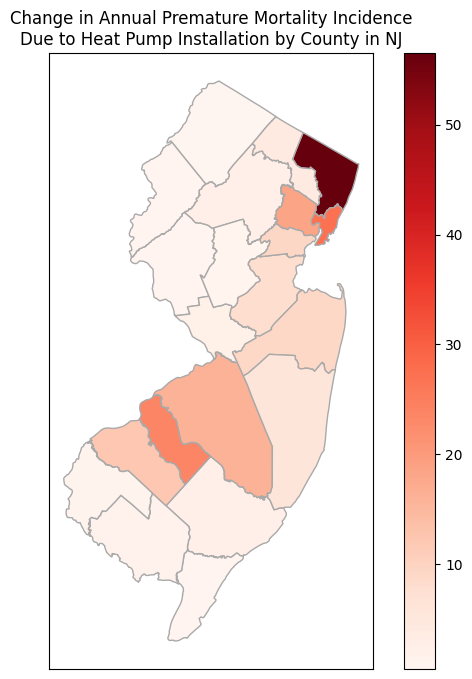

In [31]:
ax = cem.plot_map(
    gdf_map,
    "premature_mortality_incidence_delta",
    cmap="Reds",
    edgecolor="darkgray",
    figsize=(8, 8),
    legend=True
)

ax.set_title(
    "Change in Annual Premature Mortality Incidence\n"
    "Due to Heat Pump Installation by County in NJ");